# Versuch 2

Ich versuche jetzt ein Transformer-decoder only zu Trainieren, darauf trainiert wird immer nur ein Token basierend auf einer vorhergehenden sequenz vorherzusagen

# 0 import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

from data_preperation import dataset_snapshot

import math
import numpy as np

import random

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1 Data preperation

special start token

In [3]:
# Define SOS token as global variables
SOS_TOKEN = np.full((1, 88), 1)  # SOS token representation with ones (adjust for feature dimension)

load datatset

In [4]:
# Create snapshots
dataset_as_snapshots = dataset_snapshot.process_dataset_multithreaded("/home/falaxdb/Repos/minus1/datasets/maestro_v3_split/hands_split_into_seperate_midis", 0.1, amount=10)
# filter snapshots to 88 piano notes
dataset_as_snapshots = dataset_snapshot.filter_piano_range(dataset_as_snapshots)
# compress data into one octave
# dataset_as_snapshots =  dataset_snapshot.compress_existing_dataset_to_12keys(dataset_as_snapshots)

for song in dataset_as_snapshots:
    print("song:")
    for track in song:
        print(track.shape)

Processed dataset (20/20): 100%|██████████| 20/20 [00:00<00:00, 27.81it/s]

Processed 20 of 20 files
song:
(752, 88)
(752, 88)
song:
(1083, 88)
(1083, 88)
song:
(2220, 88)
(2220, 88)
song:
(3707, 88)
(3707, 88)
song:
(2730, 88)
(2730, 88)
song:
(3464, 88)
(3464, 88)
song:
(2981, 88)
(2981, 88)
song:
(3805, 88)
(3805, 88)
song:
(7862, 88)
(7862, 88)
song:
(14334, 88)
(14334, 88)


batchen, splitten, etc

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.optim import Adam



# Function to add SOS token at the start of each song and create sequences
# inputs are right and left hand combined, target is the one snapshot of the left hand
def create_sequences_with_sos(data, seq_length):
    inputs = []
    targets = []
    for song in data: 
        right_h = song[0]
        left_h = song[1]
        
        assert right_h.shape == left_h.shape, "Tracks must have same dimensions"
        
        combined_tracks = np.bitwise_xor(right_h, left_h)
        
        combined_tracks = np.vstack((sos_token, combined_tracks))
        
        for i in range(len(right_h) - seq_length):
            inputs.append(combined_tracks[i:i + seq_length])
            targets.append(left_h[i + seq_length])
    return np.array(inputs), np.array(targets)



# Dataset class
class PianoDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return {
            'input_seq': torch.tensor(input_seq, dtype=torch.float32),
            'target_seq': torch.tensor(target_seq, dtype=torch.float32)
        }



# Collate function to handle padding and creating attention masks
def collate_fn(batch):
    inputs = [item['input_seq'] for item in batch]
    targets = [item['target_seq'] for item in batch]
    
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=padding_value)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=padding_value)
    
    attention_mask = (inputs_padded != padding_value).float()
    
    return {
        'input_seq': inputs_padded,
        'target_seq': targets_padded,
        'attention_mask': attention_mask
    }


    

In [6]:
sos_token = SOS_TOKEN
padding_value = -1  # Use -1 for padding

# Parameters
seq_length = 50  # Example sequence length

# Split the dataset using sklearn while maintaining pairs
train_data, temp_data = train_test_split(dataset_as_snapshots, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

# Create sequences for right and left hand data with SOS token
train_inputs, train_targets = create_sequences_with_sos(train_data, seq_length)
val_inputs, val_targets = create_sequences_with_sos(val_data, seq_length)
test_inputs, test_targets = create_sequences_with_sos(test_data, seq_length)

# Create the dataset
train_dataset = PianoDataset(train_inputs, train_targets)
val_dataset = PianoDataset(val_inputs, val_targets)
test_dataset = PianoDataset(test_inputs, test_targets)

# Create DataLoader with collate_fn
batch_size = 32


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


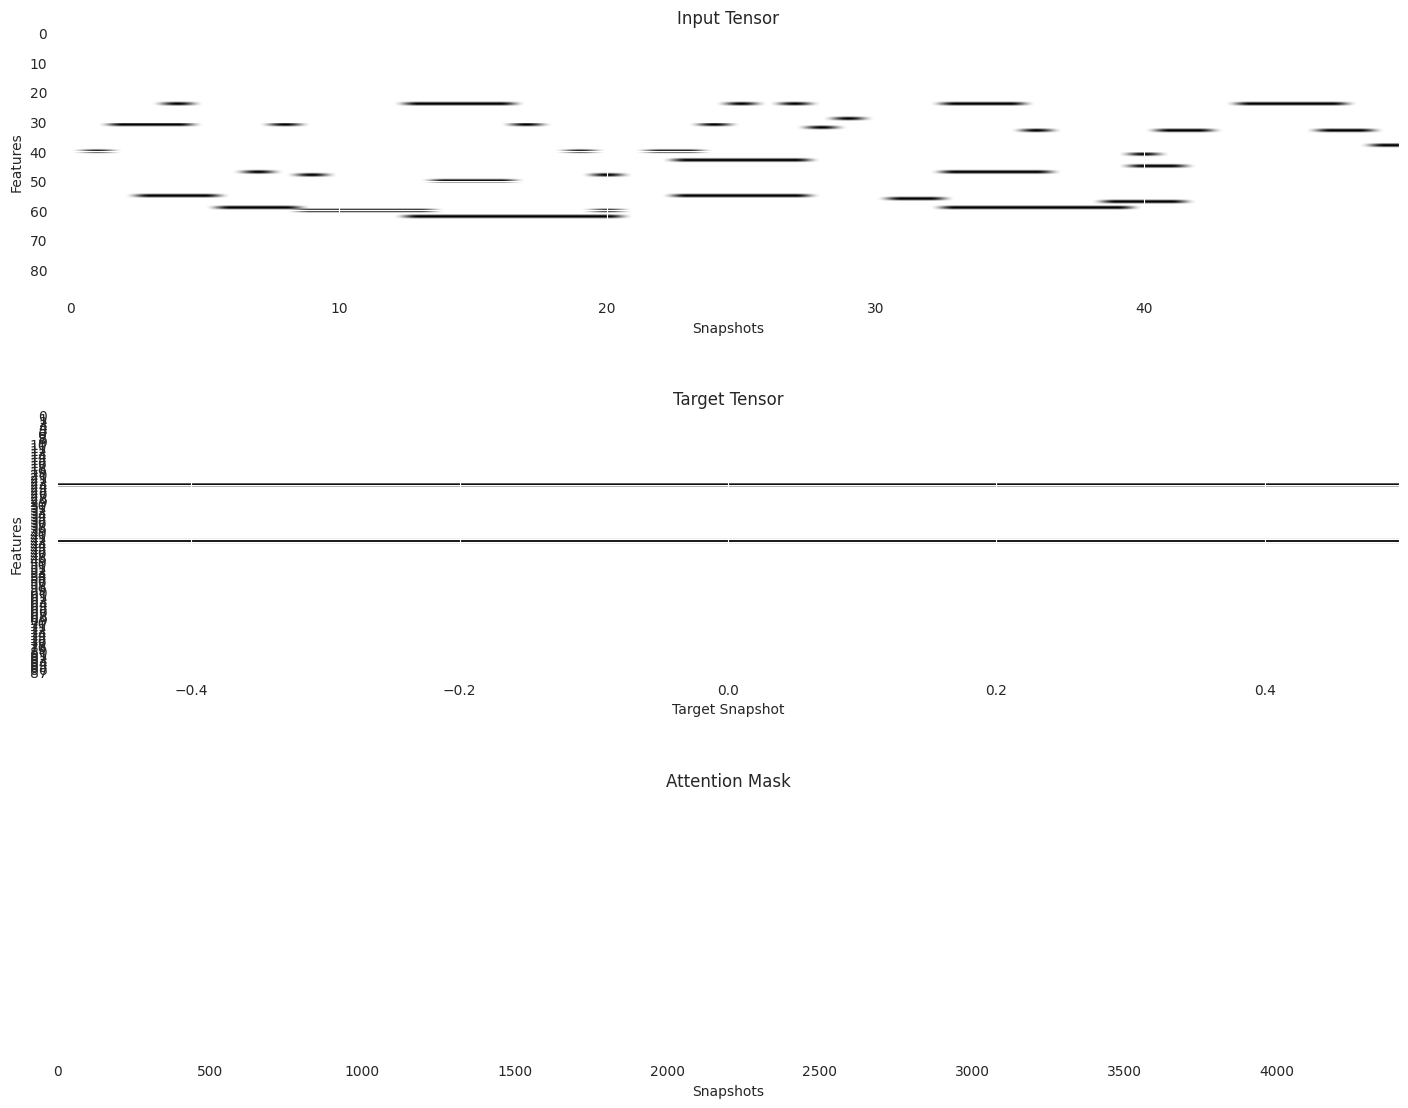

In [7]:
import matplotlib.pyplot as plt

def visualize_tensors(input_tensor, target_tensor, attention_mask):
    """
    Visualizes the input tensor, target tensor, and attention mask.
    
    Parameters:
    - input_tensor: torch.Tensor of shape (seq_length, feature_dim)
    - target_tensor: torch.Tensor of shape (feature_dim)
    - attention_mask: torch.Tensor of shape (seq_length)
    """
    input_np = input_tensor.numpy().T  # Transpose to get features on the y-axis
    target_np = target_tensor.numpy()
    attention_mask_np = attention_mask.numpy()
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    axes[0].imshow(input_np, cmap='binary', aspect='auto')
    axes[0].set_title('Input Tensor')
    axes[0].set_xlabel('Snapshots')
    axes[0].set_ylabel('Features')
    
    axes[1].imshow(target_np.reshape(-1, 1), cmap='binary', aspect='auto')
    axes[1].set_title('Target Tensor')
    axes[1].set_xlabel('Target Snapshot')
    axes[1].set_yticks(np.arange(target_np.shape[0]))
    axes[1].set_yticklabels(np.arange(target_np.shape[0]))
    axes[1].set_ylabel('Features')
    
    axes[2].imshow(attention_mask_np.reshape(1, -1), cmap='binary', aspect='auto')
    axes[2].set_title('Attention Mask')
    axes[2].set_xlabel('Snapshots')
    axes[2].set_yticks([])  # Hide y-axis

    plt.tight_layout(pad=4.0)
    plt.show()

# Get a batch of data
batch = next(iter(train_loader))

# Extract the first example from the batch
input_tensor = batch['input_seq'][0]
target_tensor = batch['target_seq'][0]
attention_mask = batch['attention_mask'][0]

print(input_tensor)
print(target_tensor)
print(attention_mask)

# Visualize the example
visualize_tensors(input_tensor, target_tensor, attention_mask)

# 2 Define model

positional and mask

In [8]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Info
        self.dropout = nn.Dropout(p=dropout)
        
        # Encoding - From formula -> This is basically applying the formula for Positional encoding (The one with Sinus and Cosinus)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # Baically a positions list 0, 1, 2, 3, 4, 5, ...
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # 1000^(2i/dim_model)
        
        # # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        
        #  # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pe[:, 1::2] = torch.cos(position * div_term)
        
         # Saving buffer (same as parameter without gradients needed)
        # pe = pe.unsqueeze(0).transpose(0, 1)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (1, max_len, d_model) Änderung evtl. wegen batch first = True
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        
        # Residual connection + pos encoding
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    
    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]
    
    return mask

# Die Funktion create_mask erstellt sowohl Quell- als auch Ziel-Pad-Masken, indem sie prüft, ob Elemente in der Quell- und Zielsequenz gleich dem Pad-Token sind. Diese Masken werden transponiert, um die richtige Dimension zu erhalten.
def create_mask(tgt):
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    return tgt_mask

Transformer

In [9]:
class TransformerDecoderModel(nn.Module):
    def __init__(self, input_dim, embed_dim, nhead, num_decoder_layers, dim_feedforward, dropout=0.1, max_len=5000):
        super(TransformerDecoderModel, self).__init__()
        self.model_type = 'Transformer'
        
        # Hier werden die Layers des modells definiert
        
        # Input token werden zu embedding vektoren umgewandelt -> hier einfach mit linearer schicht
        # input dimension wird zu embed_dim transformiert. embed dim ist die dimension meiner embeddings
        self.embedding = nn.Linear(input_dim, embed_dim)
        
        # Positional encoding schicht für infos zu reihenfolge
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        
        # hier werden die Decoder layers und der stack an layers (der transformer definiert)
        decoder_layers = nn.TransformerDecoderLayer(embed_dim, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_decoder_layers)
        
        # output schicht, um die wahrscheinlichkeit für die features
        self.generator = nn.Linear(embed_dim, input_dim)
        
        # Sigmoid für zwischen 0 und 1 
        self.sigmoid = nn.Sigmoid()

    def forward(self, src, attention_mask, tgt_mask=None):
        tgt = self.embedding(src)
        tgt = self.pos_encoder(src)  # Apply positional encoding
        
        src_key_padding_mask = attention_mask == 0
        
        output = self.transformer_decoder(src, src, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask)
        output = self.generator(output)
        
        output = self.sigmoid(output[:, -1, :])
        return output

# 3 train model

In [10]:
# Hyperparameters
input_dim = 88 # Dimension der eingehenden tokens
embed_dim = 128  # Embedding dimension
nhead = 4 # anzahl der attention heads
num_decoder_layers = 3 # anzahl der decoder layer (die Blöcke übereinander)
dim_feedforward = 128 # dimension des feedforward neural nets
dropout = 0.1
# batch_size = 32 oben festgelegt
num_epochs = 10
learning_rate = 0.001
max_len = 200  # Maximum length of the sequences -> abbruch ohne end token

In [11]:
# Modell initialisieren
model = TransformerDecoderModel(input_dim, embed_dim, nhead, num_decoder_layers, dim_feedforward, dropout, max_len)
# auf GPU laden
model = model.to(DEVICE)

# Kostenfunktion festlegen 
loss_fn = nn.BCELoss()

# optimizer festlegen
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training

In [12]:
def debug_shapes_and_ranges(X, y, output):
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Output shape:", output.shape)
    print("Output range:", torch.min(output).item(), torch.max(output).item())
    print("y range:", torch.min(y).item(), torch.max(y).item())

def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        # Move data to GPU
        input_seq = batch['input_seq'].to(DEVICE)
        target_seq = batch['target_seq'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        
        # Get mask to mask out the next words
        tgt_mask = create_mask(input_seq).to(DEVICE)

        # Standard training except we pass in y_input and tgt_mask
        # X ist unser Memory
        logits = model(input_seq, attention_mask, tgt_mask=tgt_mask)
        
        #print("Training: prediction (model output) shape:", logits.shape)
        # Debug shapes and ranges
        # debug_shapes_and_ranges(X, y, logits)
        
        # Calculate the loss
        loss = loss_fn(logits, target_seq)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

def validation_loop(model, loss_fn, dataloader):
    total_loss = 0
    
    for batch in dataloader:
        # Move data to GPU
        input_seq = batch['input_seq'].to(DEVICE)
        target_seq = batch['target_seq'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        
        # Get mask to mask out the next words
        tgt_mask = create_mask(input_seq).to(DEVICE)

        # Standard training except we pass in y_input and tgt_mask
        # X ist unser Memory
        logits = model(input_seq, attention_mask, tgt_mask=tgt_mask)
        
        #print("Training: prediction (model output) shape:", logits.shape)
        # Debug shapes and ranges
        # debug_shapes_and_ranges(X, y, logits)
        
        # Calculate the loss
        loss = loss_fn(logits, target_seq)
        
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [14]:
from timeit import default_timer as timer
NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_loop(model, optimizer, loss_fn, train_loader)
    end_time = timer()
    val_loss = validation_loop(model, loss_fn, val_loader)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

RuntimeError: The size of tensor a (88) must match the size of tensor b (128) at non-singleton dimension 2

# 4 Inferenz

# 5 output analysieren